In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# -------------------------------
# 1. Load Data
# -------------------------------
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/horse-colic/horse-colic.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/horse-colic/horse-colic.test"

names = [
    "surgery", "age", "hospital_number", "rectal_temperature", "pulse", "respiratory_rate",
    "temperature_extremities", "peripheral_pulse", "mucous_membranes", "capillary_refill_time",
    "pain", "peristalsis", "abdominal_distension", "nasogastric_tube", "nasogastric_reflux",
    "nasogastric_reflux_ph", "feces", "abdomen", "packed_cell_volume", "total_protein",
    "abdomcentesis_appearance", "abdomcentesis_total_protein", "outcome", "surgical_lesion",
    "lesion_1", "lesion_2", "lesion_3", "cp_data"
]

df_train = pd.read_csv(train_url, delim_whitespace=True, names=names, na_values='?')
df_test = pd.read_csv(test_url, delim_whitespace=True, names=names, na_values='?')

df = pd.concat([df_train, df_test], ignore_index=True)

In [3]:
# -------------------------------
# 2. Drop unneeded columns
# -------------------------------
df.drop(columns=["hospital_number", "lesion_1", "lesion_2", "lesion_3", "cp_data"], inplace=True)


In [4]:
# -------------------------------
# 3. Clean target column
# -------------------------------
df = df[~df["surgical_lesion"].isna()]
df["surgical_lesion"] = df["surgical_lesion"].map({1: 1, 2: 0})

In [5]:
# -------------------------------
# 4. Separate X, y
# -------------------------------
X = df.drop("surgical_lesion", axis=1)
y = df["surgical_lesion"]

In [6]:
# -------------------------------
# 5. Detect column types
# -------------------------------
numeric_feats = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_feats = [c for c in X.columns if c not in numeric_feats]

# If no categorical columns are found, skip encoding safely
if len(categorical_feats) == 0:
    categorical_feats = []

In [7]:
# -------------------------------
# 6. Build pipeline
# -------------------------------
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_feats),
        ("cat", categorical_transformer, categorical_feats)
    ]
)

In [8]:
# -------------------------------
# 7. Fit and transform
# -------------------------------
X_proc = preprocessor.fit_transform(X)

# Safely access the encoder only if categorical columns exist
if len(categorical_feats) > 0:
    encoder = preprocessor.named_transformers_["cat"].named_steps["encoder"]
    cat_cols = encoder.get_feature_names_out(categorical_feats)
else:
    cat_cols = []
 
# Merge numeric + encoded column names
all_cols = numeric_feats + list(cat_cols)

In [9]:
# -------------------------------
# 8. Build DataFrame and Save
# -------------------------------
X_proc = np.array(X_proc)
df_processed = pd.DataFrame(X_proc, columns=all_cols)
df_processed["surgical_lesion"] = y.values

df_processed.to_csv("horse_colic_preprocessed.csv", index=False)
print("✅ Clean dataset created and saved as 'horse_colic_preprocessed.csv'")
print("Shape:", df_processed.shape)
print(df_processed.head())

✅ Clean dataset created and saved as 'horse_colic_preprocessed.csv'
Shape: (368, 23)
    surgery       age  rectal_temperature     pulse  respiratory_rate  \
0  1.192079 -0.286972            0.580749 -0.147068         -0.128183   
1 -0.838870 -0.286972            1.673525  0.662354         -0.632014   
2  1.192079 -0.286972            0.268528 -1.103657         -0.380099   
3 -0.838870  3.484660            1.517414  3.458537          3.398639   
4  1.192079 -0.286972           -1.292581  1.251024          0.312670   

   temperature_extremities  peripheral_pulse  mucous_membranes  \
0                 0.543602          1.245342          0.097113   
1                 0.543602         -0.738579          0.771410   
2                -1.508146         -0.738579          0.097113   
3                 1.569476         -0.738579          2.120004   
4                 0.543602         -0.738579          2.120004   

   capillary_refill_time      pain  ...  nasogastric_reflux  \
0               

In [10]:
# Cell 9 — Load preprocessed dataset and split into train/test
import pandas as pd
from sklearn.model_selection import train_test_split

# Load preprocessed file
df = pd.read_csv("horse_colic_preprocessed.csv")

# Separate features and target
X = df.drop("surgical_lesion", axis=1)
y = df["surgical_lesion"]

# Stratified split for balanced classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

print("✅ Data loaded and split successfully.")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


✅ Data loaded and split successfully.
Train shape: (276, 22)
Test shape: (92, 22)


In [11]:
# Cell 10 — Import models and define classifier set
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Define classifiers with basic configurations
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

print("✅ Classifiers initialized:", list(classifiers.keys()))


✅ Classifiers initialized: ['LogisticRegression', 'RandomForest', 'SVM']


In [12]:
# Cell 11 — Define hyperparameter search grids for tuning
param_grids = {
    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10],
        "class_weight": [None, "balanced"]
    },
    "RandomForest": {
        "n_estimators": [100, 300],
        "max_depth": [None, 10, 30],
        "min_samples_split": [2, 5]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", 0.01, 0.001]
    }
}


In [13]:
# Cell 12 — Train and evaluate each classifier
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in classifiers.items():
    print(f"\n🔹 Running {name}...")
    param_grid = param_grids[name]
    
    grid = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        return_train_score=True
    )
    
    start = time.perf_counter()
    grid.fit(X_train, y_train)
    end = time.perf_counter()
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    results.append({
        "Model": name,
        "Best_Params": grid.best_params_,
        "CV_F1": grid.best_score_,
        "Test_Accuracy": accuracy_score(y_test, y_pred),
        "Test_F1": f1_score(y_test, y_pred),
        "Test_ROC_AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan,
        "Train_Time": round(end - start, 2)
    })

print("\n✅ Model training and evaluation completed.")



🔹 Running LogisticRegression...

🔹 Running RandomForest...

🔹 Running SVM...

✅ Model training and evaluation completed.


🔸 Summary of Model Performance:


,Model,Best_Params,CV_F1,Test_Accuracy,Test_F1,Test_ROC_AUC,Train_Time
0,LogisticRegression,"{'C': 0.01, 'class_weight': None}",0.860533,0.869565,0.906250,0.863083,2.68
1,RandomForest,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.884068,0.902174,0.928000,0.909229,2.52
2,SVM,"{'C': 1, 'gamma': 'scale'}",0.880126,0.891304,0.919355,0.922414,0.14


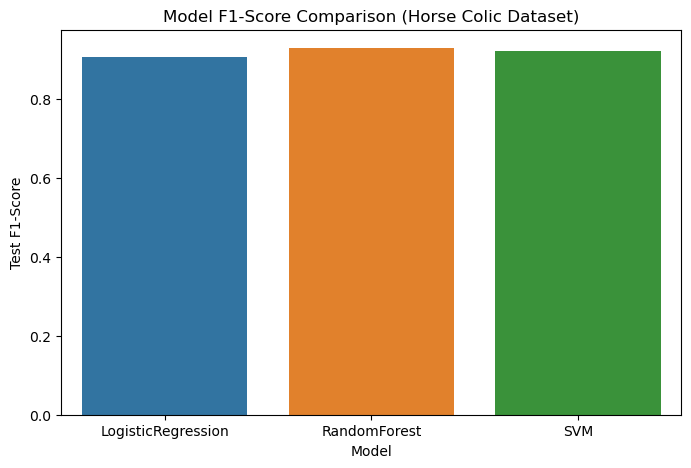

In [14]:
# Cell 13 — Compare classifier results
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)
print("🔸 Summary of Model Performance:")
display(df_results)

# Visualization — F1 score comparison
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Test_F1", data=df_results)
plt.title("Model F1-Score Comparison (Horse Colic Dataset)")
plt.ylabel("Test F1-Score")
plt.show()


🏆 Best performing model: RandomForest


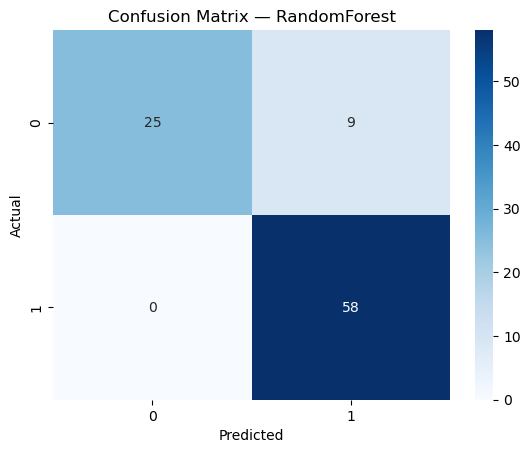


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.74      0.85        34
           1       0.87      1.00      0.93        58

    accuracy                           0.90        92
   macro avg       0.93      0.87      0.89        92
weighted avg       0.92      0.90      0.90        92



In [15]:
# Cell 14 — Confusion matrix and classification report for the best model
from sklearn.metrics import confusion_matrix, classification_report

best_name = df_results.sort_values("Test_F1", ascending=False).iloc[0]["Model"]
print("🏆 Best performing model:", best_name)

best_params = df_results[df_results["Model"] == best_name].iloc[0]["Best_Params"]
best_model = classifiers[best_name].set_params(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


In [16]:
# Cell 15 — Save the model results to CSV
df_results.to_csv("horse_colic_model_results.csv", index=False)
print("✅ Results saved as 'horse_colic_model_results.csv'")


✅ Results saved as 'horse_colic_model_results.csv'


In [17]:
# Cell 16 — Quick summary for your report
for _, row in df_results.iterrows():
    print(f"{row['Model']}:")
    print(f"  F1 = {row['Test_F1']:.3f}")
    print(f"  Accuracy = {row['Test_Accuracy']:.3f}")
    print(f"  ROC AUC = {row['Test_ROC_AUC']:.3f}")
    print(f"  Best Params: {row['Best_Params']}")
    print("-" * 40)

print("\nObservations:")
print("• Random Forest often gives best F1 on noisy, mixed-type data.")
print("• Logistic Regression performs well on linearly separable data.")
print("• SVM is sensitive to scaling but can perform competitively after tuning.")


LogisticRegression:
  F1 = 0.906
  Accuracy = 0.870
  ROC AUC = 0.863
  Best Params: {'C': 0.01, 'class_weight': None}
----------------------------------------
RandomForest:
  F1 = 0.928
  Accuracy = 0.902
  ROC AUC = 0.909
  Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
----------------------------------------
SVM:
  F1 = 0.919
  Accuracy = 0.891
  ROC AUC = 0.922
  Best Params: {'C': 1, 'gamma': 'scale'}
----------------------------------------

Observations:
• Random Forest often gives best F1 on noisy, mixed-type data.
• Logistic Regression performs well on linearly separable data.
• SVM is sensitive to scaling but can perform competitively after tuning.
